In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
import scipy.linalg as la
from scipy.interpolate import interp1d
import sys
if ".." not in sys.path: sys.path.append("..")
from common import constants, cosmology

# $\mathrm{B} - \mathrm{L}$ Genesis

## Warning: for different epoch change numbers!

In [68]:
g2 = 0.55
g3 = 0.6

def g_to_alpha(g): return (g / (4*np.pi))**2

alpha_2 = g_to_alpha(g2)
alpha_3 = g_to_alpha(g3)

Y_tau = 1e-2
Y_top = 0.49
Y_bottom = 6.8e-3

kappa_tau = 1.7e-3

def calc_yukawa_rate(T, kappa, Y):
    return kappa * Y**2 * T**4

def calc_yukawa_rate_tau(T):
    return calc_yukawa_rate(T, kappa_tau, Y_tau)

# log log -> no
# log linear -> no

kappa_quarks_uptype = np.array([8e-3, 1e-2, 1.2e-2]) # \approx downtype
T_for_kappa_quarks_uptype = np.array([1e15, 1e12, 1e9])
kappa_quark_uptype_interp = interp1d(T_for_kappa_quarks_uptype, kappa_quarks_uptype)

def calc_yukawa_rate_quark(T, Y):
    kappa = kappa_quarks_uptype[1] # kappa_quark_interp(T)
    return calc_yukawa_rate(T, kappa, Y)

def calc_yukawa_rate_top(T):
    return calc_yukawa_rate_quark(T, Y_top)

def calc_yukawa_rate_bottom(T):
    return calc_yukawa_rate_quark(T, Y_bottom)

In [3]:
def calc_sphaleron_rate(T, N_H, N_c
                        , alpha, N_f=6):
    some_number = 3.041
    g = np.sqrt(4*np.pi*alpha)
    m_D = np.sqrt((2*N_c + N_f + N_H) / 6 * g**2 * T**2)

    def gamma_eq(gamma):
        return gamma - N_c * alpha * T * (np.log(m_D / gamma) + some_number)
    p = - some_number * N_c * alpha * T
    q = - N_c * alpha * T * m_D
    guess = -p/2 + np.sqrt((p/2)**2 - q)
    sol = root(gamma_eq, guess)
    if not sol.success: return np.nan
    gamma = sol.x[0]

    Gamma_sphal = ( 
        0.21 / 2 * (N_c * g**2 * T**2 / m_D**2) * 
        (np.log(m_D / gamma) + some_number) * 
        (N_c**2 - 1) / N_c**2 * 
        (N_c * alpha)**5 * T**4
    )
    return Gamma_sphal

kappa_WS = 24 # for 1e12 GeV
kappa_SS = 2.7e2 # for 1e13 GeV

def calc_weak_sphaleron_rate(T):
    return kappa_WS / 2 * alpha_2**5 * T**4
    # return calc_sphaleron_rate(T, N_H=1, N_c=2, alpha=alpha2_running(T))

def calc_strong_sphaleron_rate(T):
    return kappa_SS / 2 * alpha_3**5 * T**4
    # return calc_sphaleron_rate(T, N_H=0, N_C=3, alpha=alpha3_running(T))

In [441]:
charge_vector = np.array((
    # Interactions:
    # tau, L12, L3, q12, t,  b,  Q12, Q3,  H
    (0,    2,   1,  0,   0,  0,  6,   3,   0), # WS
    (0,    0,   0, -4,  -1, -1,  4,   2,   0), # SS
    (-1,   0,   1,  0,   0,  0,  0,   0,   1), # Y_tau
    (0,    0,   0,  0,  -1,  0,  0,   1,   1), # Y_top
    (0,    0,   0,  0,   0, -1,  0,   1,  -1), # Y_bottom
    (0,    2,   0,  0,   0,  0,  0,   0,   2), # Weinberg_12
    (0,    0,   2,  0,   0,  0,  0,   0,   2), # Weinberg_3
    # Conserved Quantaties:
    # tau, L12,  L3,   q12,   t,    b,  Q12,   Q3,  H
    #( -1, -1/2, -1/2,  1/6,  2/3, -1/3, 1/6,  1/6, 1/2), # Y
    #(  0,  0,    0,    1/3, -2/3, -2/3, 1/3, -2/3, 0),   # B12 - 2*B3
))

In [442]:
g = dofs = np.array([1,4,2,12,3,3,12,6,4])

In [443]:
kappa_W = 3e-3
nu_EW = 174 # [GeV]
m_nu = 0.05 # np.sqrt(2.4e-3)
def calc_weinberg_op_rate(T):
    return kappa_W * m_nu**2 * T**6 / nu_EW**4

In [444]:
def calc_rate_vector(T):
    return np.array((
        calc_weak_sphaleron_rate(T), # WS
        calc_strong_sphaleron_rate(T), # SS
        calc_yukawa_rate_tau(T), # Y_tau
        calc_yukawa_rate_top(T), # Y_top
        calc_yukawa_rate_bottom(T), # Y_bottom
        2 * calc_weinberg_op_rate(T), # W_12
        calc_weinberg_op_rate(T), # W_3
    ))

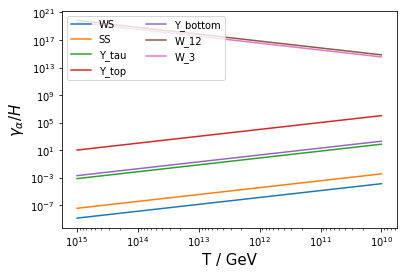

In [445]:
T_RH = 1e15
process_names = ["WS", "SS", "Y_tau", "Y_top", "Y_bottom", "W_12", "W_3"]
T_range = np.geomspace(T_RH, 1e10, 100)
H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_range))
for name, rate in zip(process_names, np.vstack([calc_rate_vector(T) / (T**3 / 6) for T in T_range]).T):
    plt.loglog(T_range, rate / H, label=name)
plt.legend(ncol=2, loc=2)
plt.xlabel("T / GeV", fontsize=15)
plt.ylabel(r"$\gamma_\alpha / H$", fontsize=15)
plt.gca().invert_xaxis()

In [446]:
#                                           WS SS  Ytau Yt Yb  W12  W3 
source_vector_B_minus_L_current = np.array((0,  0,  0,  0,  0, -2, -2))
source_vector_weak_sphaleron    = np.array((1,  0,  0,  0,  0,  0,  0))
source_vector_strong_sphaleron  = np.array((0,  1,  0,  0,  0,  0,  0))

In [447]:
# a dot / f / T
eta0 = 1e-9
def calc_axion_motion(T):
    return eta0

In [448]:
charge_names = ["tau", "L12", "L3", "q12", "t", "b", "Q12", "Q3", "H"]

In [449]:
charge_vector_B_minus_L = np.array((-1, -1, -1, 1/3, 1/3, 1/3, 1/3, 1/3, 0))
def calc_B_minus_L(red_chems):
    return np.dot(charge_vector_B_minus_L, red_chems)

In [450]:
def rate_per_time_vol_to_rate_per_time(Gamma, T):
    return Gamma / (T**3 / 6)

In [460]:
def transport_eq_rhs(log_T, red_chem_pot, n_S):
    n = charge_vector
    T = np.exp(log_T)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    Gamma = calc_rate_vector(T)
    gamma = rate_per_time_vol_to_rate_per_time(Gamma, T)
    axion_motion = calc_axion_motion(T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H * 
                       (# sum(n[alpha, j] * red_chem_pot[j] for j in range(n.shape[1])) 
                        n[alpha, :] @ red_chem_pot
                        - n_S[alpha] * axion_motion) 
                    for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    return d_red_chem_pot_d_ln_T

In [461]:
initial = np.repeat(0, charge_vector.shape[1])
T_RH = 1e15
start = np.log(T_RH)
end = np.log(1e10)
num_steps = 500
steps = np.linspace(start, end, num_steps)
steps[0] = start; steps[-1] = end
sol = solve_ivp(transport_eq_rhs, (start, end), initial, 
         args=(source_vector_weak_sphaleron,), 
         method="Radau", rtol=1e-8, t_eval=steps) # methods: RK45, DOP853, Radau, BDF, LSODA

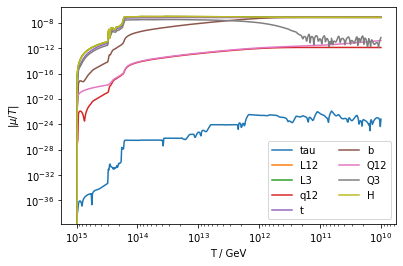

In [462]:
for name, y in zip(charge_names, sol.y):
    T = np.exp(sol.t)
    plt.loglog(T, np.abs(y), label=name)
plt.ylabel(r"$|\mu / T|$")
plt.xlabel(r"T / GeV")
plt.gca().invert_xaxis()
plt.legend(ncol=2)
plt.show()

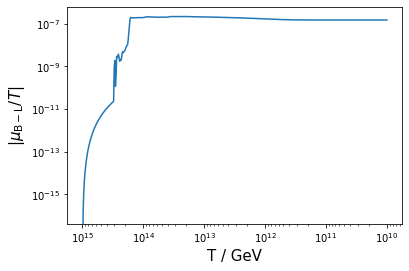

In [463]:
red_chem_B_minus_L = calc_B_minus_L(sol.y)
plt.loglog(np.exp(sol.t), np.abs(red_chem_B_minus_L))
plt.ylabel(r"$|\mu_{\mathrm{B} - \mathrm{L}} / T|$", fontsize=15)
plt.xlabel(r"T / GeV", fontsize=15)
plt.gca().invert_xaxis()
plt.show()

In [352]:
red_chem_B_minus_L * np.exp(sol.t)

array([ 0.00000000e+00, -8.35548423e-03, -6.96382603e-02, -1.53330043e-01,
        1.40926829e+01,  3.03160046e+02,  1.31225339e+03,  3.45714887e+03,
        4.72576049e+03,  6.52606703e+03,  7.50701255e+03,  1.34707527e+04,
        1.88607490e+04,  1.81579080e+04,  1.75173033e+04,  1.69279315e+04,
        1.63796267e+04,  1.58627121e+04,  1.53686189e+04,  1.48885976e+04,
        1.44144981e+04,  1.39388892e+04,  1.34550175e+04,  1.30758163e+04,
        1.27580943e+04,  1.24515107e+04,  1.21544549e+04,  1.18654402e+04,
        1.15830965e+04,  1.13060891e+04,  1.10332847e+04,  1.07635352e+04,
        1.04957155e+04,  1.02288040e+04,  9.96187565e+03,  9.69409698e+03,
        9.42472039e+03,  9.15307903e+03,  8.91377868e+03,  8.71411219e+03,
        8.51841994e+03,  8.32736676e+03,  8.14148689e+03,  7.96141344e+03,
        7.78771235e+03,  7.62088638e+03,  7.46137889e+03,  7.30957740e+03,
        7.16581707e+03,  7.02084425e+03,  6.85885575e+03,  6.70114677e+03,
        6.54737964e+03,  